In [ ]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
# !pip install seaborn

Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [12]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2

from modules.gnn_models import GCN, GraphSAGE, GAT
from modules.graph import Graph, create_files
from modules.gnn import GNN
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

# from modules.gnn import GNN
# from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
# from modules.predictors import DotPredictor, MLPPredictor, MLPPredictorEmbeddings
# from modules.graph_from_api import Graph_API
# from dgl.sampling import pack_traces

# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim import SparseAdam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
# from utils import *
# from modules.graph import Graph
# import numpy as np
import os
# import fnmatch
# import tqdm
# import networkx as nx

# import dgl.function as fn
# from dgl.nn import DeepWalk
# from torch.utils.data import DataLoader

# from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# from bgp2vec.bgp2vec import BGP2VEC


print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [34]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [35]:
# Definimos las rutas de los archivos
BASE_PROJECT_PATH = os.getcwd() + "/data/"
RELATIONSHIPS_FILE  = BASE_PROJECT_PATH + "CAIDA_AS_Relationships/Serial_1/20220701.as-rel.txt.bz2"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_feature_mio.csv" #"/node_features.csv" 
rib_path = BASE_PROJECT_PATH + 'sanitized_rib.txt'
MES = 'febrero'
dataset_graph_path = BASE_PROJECT_PATH + f'dgl_graph/{MES}/'
MAX_NUM_ROUTES = 1000000

## Creacion Grafo 
Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 

### CASO 1: RIBs
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream
* Por ahora le asignamos a todos los nodos embeddings iniciales de de dimension 32 parte con puros 1s todos


In [ ]:
ls /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024

rib_abril_2024.txt*            sanitized_rib_enero_2024.txt*
rib_enero_2024.txt*            sanitized_rib_febrero_2024.txt*
rib_marzo_2024.txt*            sanitized_rib_marzo_2024.txt*
sanitized_rib_abril_2024.txt*


In [36]:
# Informacion del analisis para la configuracion
MES = 'febrero'
ANO = '2024'

In [37]:
# Ruta a la data base del proyecto
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# Archivo etiqueta las relaciones
LABEL_EDGES_FILE = DATA_PATH + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'

# Archivo con RIBs
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'

In [33]:
# Definimos las listas de features

# features_file = 'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# features_file = base_path + "/node_features.csv"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_features_mio_febrero.csv"
# FEATURES_FILE = 'node_features_mio_febrero.csv'
attr = 'node_features_mio_febrero.csv' # 'mio_attr' # 'degree' # 'node_features_mio_febrero.csv'
rib_path = BASE_PROJECT_PATH + 'sanitized_rib_febrero_2024.txt'
MAX_NUM_ROUTES = 1000000
label_edges_file = BASE_PROJECT_PATH + 'edges_labels.csv'
graph_case1 = create_files(
            output_dir = OUTPUT_DIR,
            rib_file = RIB_FILE, 
            features_file = FEATURES_FILE, 
            from_caida = False, 
            label_edges_file = LABEL_EDGES_FILE,
            remove_degree=3,
            debug=True,
            max_paths = MAX_NUM_ROUTES)

print('[NX Graph]',graph_case1.nx_graph)

[CARPETA CREADA]:  /home/valentina/Desktop/GIT/TrabajoTesis/data/dgl_graph/febrero/
[Creando topologia desde /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt]
[NX Graph]:  DiGraph with 42242 nodes and 149763 edges
[Agregando attr a nodos desde /home/valentina/Desktop/GIT/TrabajoTesis/data//node_features_mio_febrero.csv]
[NX Graph]:  DiGraph with 42242 nodes and 149763 edges
[Etiquetando aristas con CAIDA]
[INFO] Se eliminaron 8382 aristas sin 'Relationship'
[META CREADO]
[NX Graph eliminando]:  DiGraph with 25434 nodes and 124614 edges
[NX Graph eliminando]:  DiGraph with 25088 nodes and 124269 edges
[NX Graph eliminando]:  DiGraph with 25077 nodes and 124258 edges
[NX Graph] DiGraph with 25077 nodes and 124258 edges


### CASO 1: 
* Encoder : GNN -> (GCN , GraphSAGE, GAT)
* Decoder : DotProduct

In [38]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
gnn.split_graph_edges_basic(train_size=0.8)

Done saving data into cached files.
Graph(num_nodes=25077, num_edges=124258,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
[ATTR SHAPE]:  torch.Size([25077, 67])
Generando 124258 aristas negativas...
Aristas negativas generadas: 124257


In [15]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
# gnn.split_graph_edges(0.8)
gnn.split_graph_edges_basic(0.8)

Done saving data into cached files.
Graph(num_nodes=25196, num_edges=132717,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
[ATTR SHAPE]:  torch.Size([25196, 67])
Generando 132717 aristas negativas...
Aristas negativas generadas: 132716


In [39]:
from collections import Counter

labels_train = gnn.train_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)



labels_train = gnn.test_pos_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)


labels_train = gnn.train_pos_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)

Counter({1: 13578, 0: 11229, 2: 45})
Counter({1: 54247, 0: 45033, 2: 126})
Counter({1: 13578, 0: 11229, 2: 45})


Training model: GCN
Epoch 00000 | Loss 1.0862 | Train Acc 0.5429
Epoch 00010 | Loss 0.7148 | Train Acc 0.5464
Epoch 00020 | Loss 0.7071 | Train Acc 0.5699
Epoch 00030 | Loss 0.6669 | Train Acc 0.6759
Epoch 00040 | Loss 0.5739 | Train Acc 0.7660


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

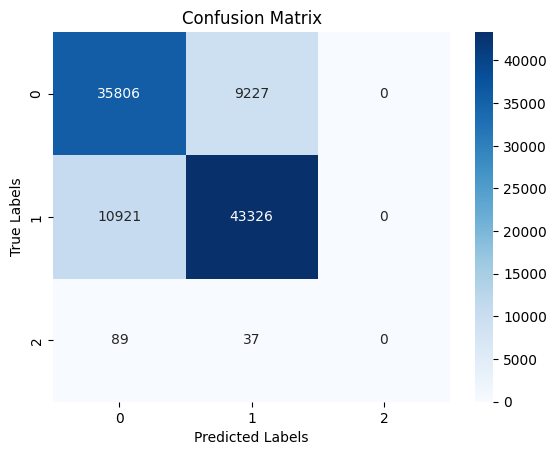

Classification Report:

              precision    recall  f1-score   support

           0     0.7648    0.7951    0.7797     45033
           1     0.8238    0.7987    0.8111     54247
           2     0.0000    0.0000    0.0000       126

    accuracy                         0.7960     99406
   macro avg     0.5296    0.5313    0.5302     99406
weighted avg     0.7961    0.7960    0.7958     99406

Training model: GraphSAGE
Epoch 00000 | Loss 0.9689 | Train Acc 0.5282
Epoch 00010 | Loss 0.3852 | Train Acc 0.8423
Epoch 00020 | Loss 0.3452 | Train Acc 0.8621
Epoch 00030 | Loss 0.3106 | Train Acc 0.8776
Epoch 00040 | Loss 0.2915 | Train Acc 0.8860


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

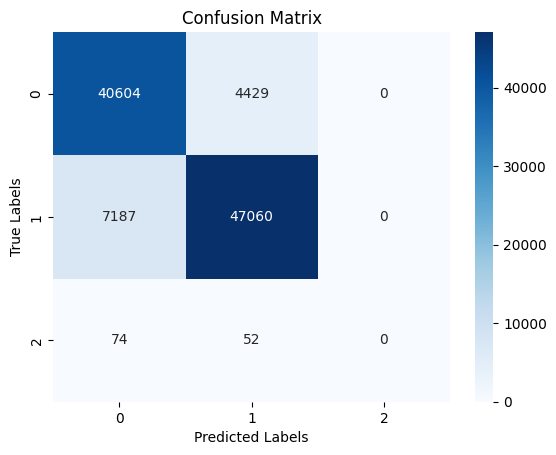

Classification Report:

              precision    recall  f1-score   support

           0     0.8483    0.9016    0.8742     45033
           1     0.9131    0.8675    0.8897     54247
           2     0.0000    0.0000    0.0000       126

    accuracy                         0.8819     99406
   macro avg     0.5871    0.5897    0.5880     99406
weighted avg     0.8826    0.8819    0.8815     99406

Training model: GAT
Epoch 00000 | Loss 1.1462 | Train Acc 0.3961
Epoch 00010 | Loss 0.7128 | Train Acc 0.5393
Epoch 00020 | Loss 0.6724 | Train Acc 0.6771
Epoch 00030 | Loss 0.5515 | Train Acc 0.7402
Epoch 00040 | Loss 0.4706 | Train Acc 0.7952


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

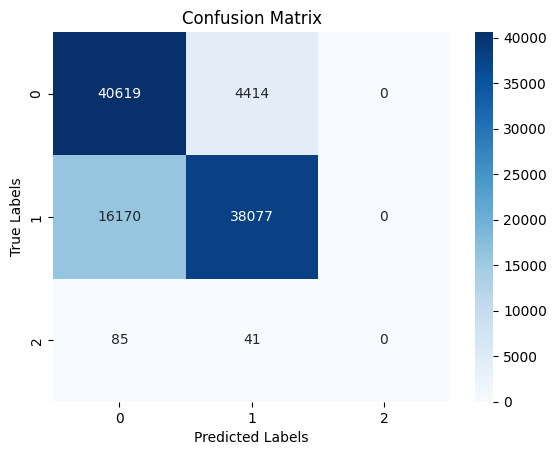

Classification Report:

              precision    recall  f1-score   support

           0     0.7142    0.9020    0.7972     45033
           1     0.8953    0.7019    0.7869     54247
           2     0.0000    0.0000    0.0000       126

    accuracy                         0.7917     99406
   macro avg     0.5365    0.5346    0.5280     99406
weighted avg     0.8121    0.7917    0.7906     99406



In [42]:
decorer = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 16
out_feats_mlp = 3
labels_train = gnn.train_g.edata["Relationship"].to(torch.int64)

for model_name in models:
    print("Training model: {}".format(model_name))
    
    model = models[model_name](
    in_feats=in_feats,
    hidden_feats=hidden_feats,
    out_feats=out_feats,
    out_feats_mlp=out_feats_mlp,)

    optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.01)

    # ----------- training -------------------------------- #
    
    
    loss_values = []
    acc_train = []
    train_error = []
    model_complexity = []

    for e in range(50):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])
        # print("h shape: ", h.shape)
        logits = model.decodeMLP(gnn.train_g, h)
        # print("Logits shape: ", logits.shape)
        scores = logits.argmax(1)

        # Calcular la pérdida en el conjunto de entrenamiento
        train_loss = F.cross_entropy(logits, labels_train)
        train_error.append(train_loss.item())
            
        # Guardar la complejidad del modelo (en este caso, usamos el número de épocas)
        model_complexity.append(e + 1)
        
        # Almacenar el valor de pérdida
        loss_values.append(train_loss.item())
        
        # Calcular la precisión en el conjunto de entrenamiento
        train_acc = (scores == labels_train).float().mean().item()

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f}".format(e, train_loss.item(), train_acc))

        
    # ----------- 5. check results ------------------------ #


    with torch.no_grad():
        h = model.encode(gnn.test_pos_g, gnn.test_pos_g.ndata["feat"])
        logits_test = model.decodeMLP(gnn.test_pos_g, h)
        # print("Logits test shape: ", logits_test.shape)
        predicted_scores_test = logits_test.argmax(1)
        true_values_test = gnn.test_pos_g.edata["Relationship"].to(torch.int64)
        
        conf_matrix = confusion_matrix(true_values_test, predicted_scores_test)
        report = classification_report(true_values_test, predicted_scores_test, digits=4)

        # Graficar la matriz de confusión
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        print("Classification Report:\n")
        print(report)  
    


    
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


     
    
